# How Supercomputers Solve Physics Problems

## The Reality of Large-Scale Computational Physics

When you hear about climate simulations, fusion reactor modeling, or astrophysics calculations running on supercomputers with millions of cores, **they're all solving linear systems at their core**.

### Key Insight
> **"At the end of the day, computational physics is about solving linear systems—just very large, very sparse, and very structured ones."**

This notebook explores:
1. **Domain Decomposition** - How to split problems across thousands of processors
2. **Iterative Methods at Scale** - Why direct methods fail for huge systems
3. **Preconditioning** - The secret to fast convergence
4. **Multigrid Methods** - Solving in O(n) time for PDEs
5. **Real Supercomputer Case Studies** - Climate, fusion, cosmology

## Why This Matters

- Climate models: 10⁹-10¹² unknowns (billions to trillions!)
- Fusion simulations: 10⁸-10⁹ unknowns
- Weather forecasting: Must solve in real-time
- Molecular dynamics: Millions of atoms, repeated thousands of times

**The Thomas algorithm is a baby step toward these industrial-scale methods!**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy import sparse
from scipy.sparse.linalg import spsolve, cg, gmres
import sys
sys.path.append('../src')

from linear_systems import build_tridiagonal, build_discrete_laplacian_1d

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (16, 10)
np.random.seed(42)

print("=" * 70)
print("SUPERCOMPUTER LINEAR ALGEBRA".center(70))
print("=" * 70)
print("\nThis notebook shows how real computational physics works!")

                     SUPERCOMPUTER LINEAR ALGEBRA                     

This notebook shows how real computational physics works!


## 1. From 1D to 2D: The Problem Explodes

### The Curse of Dimensionality

**1D Problem (what we've been doing):**
- n grid points → n×n matrix → O(n) storage with Thomas algorithm ✓

**2D Problem (realistic physics):**
- n×n grid points → (n²)×(n²) matrix → O(n⁴) storage!! ✗
- For n=1000: 1 trillion elements = **8 TB of memory**

### Example: 2D Heat Equation

$$\frac{\partial T}{\partial t} = \alpha \left(\frac{\partial^2 T}{\partial x^2} + \frac{\partial^2 T}{\partial y^2}\right)$$

Discretization creates **5-point stencil**:
$$T_{i,j}^{n+1} = T_{i,j}^n + \frac{\alpha \Delta t}{\Delta x^2}\left(T_{i-1,j} + T_{i+1,j} + T_{i,j-1} + T_{i,j+1} - 4T_{i,j}\right)$$

This becomes a linear system: $A\mathbf{T} = \mathbf{b}$ where **A is sparse but huge!**

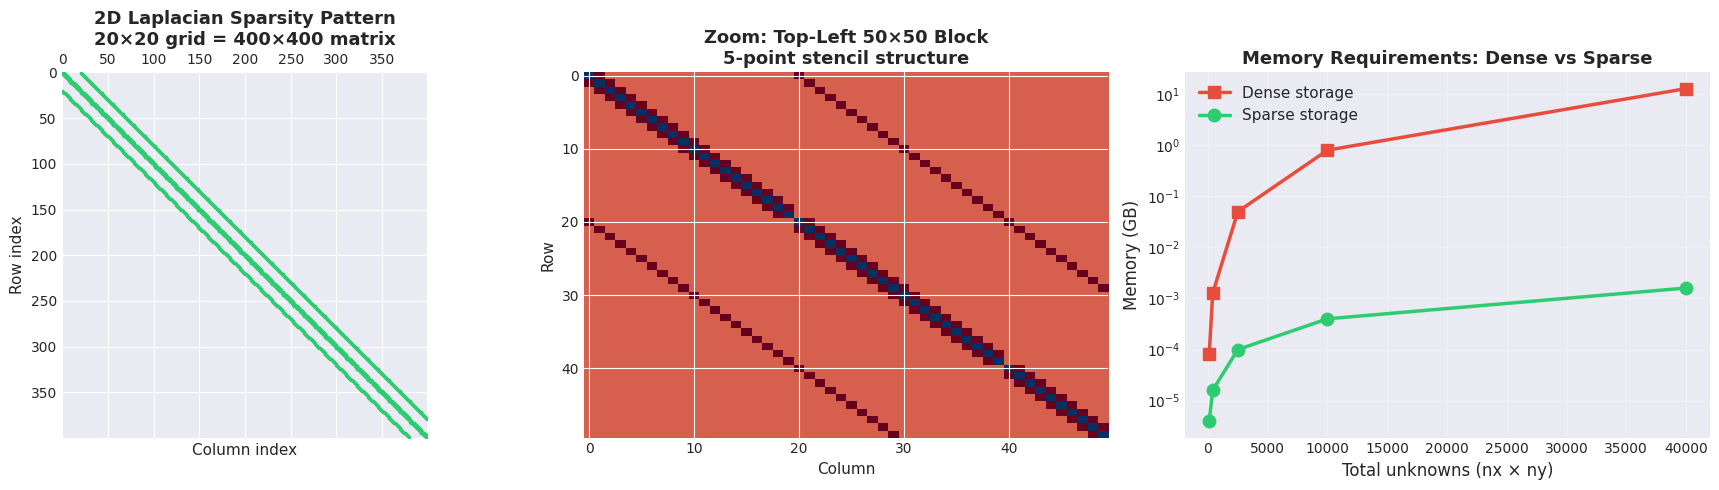


                       2D LAPLACIAN STATISTICS                        
Grid size:              20 × 20
Total unknowns:         400
Matrix size:            400 × 400
Non-zero elements:      1,920
Sparsity:               1.200% non-zero
Dense storage:          0.00 GB
Sparse storage:         0.02 MB
Memory savings:         83× reduction
✓ Sparse storage is essential for 2D/3D problems!


In [2]:
# Build 2D Laplacian matrix (5-point stencil)
def build_2d_laplacian(nx, ny):
    """
    Build 2D Laplacian matrix using finite differences.
    
    For nx × ny grid, creates (nx·ny) × (nx·ny) sparse matrix.
    Memory: O(5·nx·ny) instead of O(n⁴)
    """
    n = nx * ny
    
    # Main diagonal: -4/h²
    main_diag = -4 * np.ones(n)
    
    # Adjacent in x-direction: 1/h²
    off_diag_x = np.ones(n - 1)
    # Remove connections across x-boundaries
    off_diag_x[nx-1::nx] = 0
    
    # Adjacent in y-direction: 1/h²
    off_diag_y = np.ones(n - nx)
    
    # Build sparse matrix
    diagonals = [main_diag, off_diag_x, off_diag_x, off_diag_y, off_diag_y]
    offsets = [0, -1, 1, -nx, nx]
    
    A = sparse.diags(diagonals, offsets, format='csr')
    
    return A

# Demonstrate sparsity pattern
nx, ny = 20, 20
n = nx * ny
A_2d = build_2d_laplacian(nx, ny)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Sparsity pattern
ax1.spy(A_2d, markersize=2, color='#2ecc71')
ax1.set_title(f'2D Laplacian Sparsity Pattern\n{nx}×{ny} grid = {n}×{n} matrix', 
              fontsize=13, fontweight='bold')
ax1.set_xlabel('Column index', fontsize=11)
ax1.set_ylabel('Row index', fontsize=11)

# Zoomed view of corner
A_dense_corner = A_2d[:50, :50].toarray()
ax2.imshow(A_dense_corner, cmap='RdBu_r', aspect='auto')
ax2.set_title('Zoom: Top-Left 50×50 Block\n5-point stencil structure', 
              fontsize=13, fontweight='bold')
ax2.set_xlabel('Column', fontsize=11)
ax2.set_ylabel('Row', fontsize=11)

# Memory comparison
grid_sizes = [10, 20, 50, 100, 200]
dense_memory = [(n**2)**2 * 8 / 1e9 for n in grid_sizes]  # GB
sparse_memory = [5 * n**2 * 8 / 1e6 for n in grid_sizes]  # MB

ax3.semilogy([n**2 for n in grid_sizes], dense_memory, 's-', 
             linewidth=2.5, markersize=9, label='Dense storage', color='#e74c3c')
ax3.semilogy([n**2 for n in grid_sizes], [m/1000 for m in sparse_memory], 'o-', 
             linewidth=2.5, markersize=9, label='Sparse storage', color='#2ecc71')
ax3.set_xlabel('Total unknowns (nx × ny)', fontsize=12)
ax3.set_ylabel('Memory (GB)', fontsize=12)
ax3.set_title('Memory Requirements: Dense vs Sparse', fontsize=13, fontweight='bold')
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/2d_sparse_matrix_structure.png', dpi=300, bbox_inches='tight')
plt.show()

# Statistics
nnz = A_2d.nnz  # Number of non-zeros
sparsity = nnz / n**2 * 100

print("\n" + "=" * 70)
print("2D LAPLACIAN STATISTICS".center(70))
print("=" * 70)
print(f"Grid size:              {nx} × {ny}")
print(f"Total unknowns:         {n:,}")
print(f"Matrix size:            {n:,} × {n:,}")
print(f"Non-zero elements:      {nnz:,}")
print(f"Sparsity:               {sparsity:.3f}% non-zero")
print(f"Dense storage:          {n**2 * 8 / 1e9:.2f} GB")
print(f"Sparse storage:         {nnz * 8 / 1e6:.2f} MB")
print(f"Memory savings:         {n**2 * 8 / (nnz * 8):.0f}× reduction")
print("=" * 70)
print("✓ Sparse storage is essential for 2D/3D problems!")